# General Comments/Questions
1. Could come back to Section4, Step 2 to include bounds for different variables in random data to make it more realistic
2. Go through to ensure all variables listed are used
3. Review all comments to make sure it flows
4. Review all Sections & explanations to make sure all content is there


# 0. Import libraries

In [53]:
import pandas as pd
import numpy as np
import random
from random import randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam
import math
import matplotlib.pyplot as plt

# 1. Import household data 
* Read data from a file I created since the data input to this actual paper was the output of another DRL paper that was taking too long to implement. 
* Used Matlab to randomize household data using researched data synthetic household profiles. Read report appendix for more details. Created 5 types of homes and then distributed 32 households over these profiles as described in report and added noise to ensure dataset was not too clean.


## Input File
* InputData_HouseholdStates.xls spreadsheets each build data for implementation:
    * time  : timeslot x household
    * pmax  : maximum controllable power for a given timeslot x household
    * pmin  : minimum controllable power for a given timeslot x household
    * pbase : base power for a given timeslot x household


## Variables
* Variables created to read in data
    * d_time       : time stamp 
    * d_p_base     : base load that cannot be controlled or altered for each household 
    * d_p_ctrl_min : minimum controllable load, lowest limit for each household
    * d_p_ctrl_max : maximum controllable load, highest limit for each household

* Other varaibles
    * n            : household #

In [54]:
#
# Read in raw data
#
d_time = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "time", header=None)
d_p_base = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "pbase", header=None)
d_p_ctrl_min = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "pmin", header=None)
d_p_ctrl_max = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "pmax", header=None)

#
# Calculate number of homes
#
n = len(d_time.columns)



# 2. Compile household data with electricity price
* Create function to calculate electricity price with respect to time based on Figure 4 in paper. 
* Assume electricity price is time of use piecewise structure and applies 7-days a week, regardless if its a holiday or not. 
* Compile electricity data with data read in to produce one tuple with all data across all households.


## Variables
* tod                 : time of day (hour from 1 to 24)
* i, j                : iterators for household and timestep respectively
* input_data   : compile data of system's state with time of day (d_time), base load (d_p_base), min. controllable load (d_p_ctrl_min), max controllable load (d_p_ctrl_max), 
    * Format: input_data[household number][type of data][timeslot]
    * household number: 0 to 31
    * type of data: 0 to 4
        * 0: time
        * 1: electricity price
        * 2: baseload
        * 3: min controllable load
        * 4: max controllable load
    * timeslot: 0 to 2399

In [55]:
#
# Compile household data in usable format
#


input_data = np.empty((d_time.shape[0],5,n),dtype=object) # 5 is for the 3 power variables, time & electricity rate


def f_electricity_price(t):

    tod = t-(24*(math.ceil(t/24)-1))

    if tod < 1 or tod > 24:
            roh = "error"

    elif tod >= 19 and tod < 22:       
            roh = 4.5

    elif tod >= 16 and tod < 19:
            roh = 4

    elif (tod >= 7 and tod < 13 ) or (tod >= 22) or (tod < 4):
            roh = 2.5

    else:
            roh =1
                
    return roh

for i in range(0,n): # iterate ober household data
    for j in range (0,(len(d_time.index))): # iterate over timestep
        input_data[j][0][i] = d_time[i][j]# time stamp for house i
        input_data[j][1][i] = f_electricity_price(d_time[i][j])# electricity price for house i
        input_data[j][2][i] = d_p_base[i][j] # baseload power for house i
        input_data[j][3][i] = d_p_ctrl_min[i][j] # minimum controllable load for house i
        input_data[j][4][i] = d_p_ctrl_max[i][j] # maximum controllable load for house i
       
        
# TEST POINT
#print("Section 2: input_data table", input_data)

# 3. Intialize variables
* Initalize time & error, epsilon. Then randomly initialize DNN variables theta_pol & theta_vf.


## Variables
* Federated learning variables used in Section 4
    - t                     : time
    - epsilon               : error value 
    - num_groups            : number of groups to be formulated for federated learning
    - n_per_group           : number of houses in each group for federated learning
    - group_index           : group index number
    - household_data_groups : household data divded into groups
        * Format: household_data_groups[group number][type of data][house # in group]

* DNN variables used in Section 5
    - action_probs_history  : track all actions taken
    - state_output_history  : track all output states if action taken
    - critic_value_history  : track value function output
    - reward_history        : keep track of cost for each action, state
    - value_history         : history of all value outputs
    - prob_history          : history of probability
    - delta_history         : history of TD error
    - P_ctrl_history        : history of optimized controllable load scheduled
    - P_ctrl_cost_history   : history of optimized cost



In [56]:
#
# Initalize values
#
t = 1
epsilon = 10**-3

#
# Federated learning variables
#
num_groups = int(4)
n_per_group = int(n/num_groups)
group_index = np.linspace(0, 24, 4)
household_data_groups = np.empty((4,5,8),dtype=object)

#
# DNN variables
#           
action_probs_history = []
state_output_history = []
critic_value_history = []
reward_history = []
value_history = []
prob_history = []
delta_history = []
P_ctrl_history = []
P_ctrl_cost_history = []
load_checkpoint = False

# 4. Decentralized learning & information exchange
* For federated learning, divide up households by an arbitrary number (4 in this case) to use decentralized learning and to anonymize household data. Divide up homes into number of groups, recognizing if uneven number 1 group will have more data. 
* Create random data that will be used to mask household data when returned to aggregator. This random data is in the exact same format as p_base, p_ctrl_min, p_ctrl_max. 
* Households aggergate household data with random data sent from aggregator.
* Aggregator removes random data they added from each group to be left with the real data anonymized.
* Aggregates lamda & gamma for all household's states for base, min & max. This variable is visible to all households for DNN training.
* Read more about federated learning in report.


## Variables
- num_groups            : choose the number of groupings there should be for all households
- t_time                : time steps
- t_elec_price          : electricity price
- t_base                : baseload
- t_min                 : minimum controllable load
- t_max                 : maximum controllable load
- n_per_group           : number of houses to be included in each group
- group_index           : index for starting home in each group
- delete_index          : tracks the index of the random data that needs to be removed for secure aggregation
- household_data_groups : all household data saved in groups
- lamda_bar             : aggregate values of household data for value function
- gamma_bar             : aggregate values of household data for policy
- it, i                 : iterators
- random_data           : random data generated only aggregator knows for each group
- system_data           : system data passed using federated learning
- system_data_clean     : system data cleaned by aggregator using federated learning
- base                  : summed base power load at time t for all households
- min_ctrl              : summed minimum controllable power load at time t for all households
- max_ctrl              : summed maximum controllable power load at time t for all households

In [57]:
#
# Federated learning
#
for i in range(0,num_groups):
    t_time = input_data[t,0,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_elec_price = input_data[t,1,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_base = input_data[t,2,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_min = input_data[t,3,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_max = input_data[t,4,int(group_index[i]):int(group_index[i]+n_per_group)]
    household_data_groups[i] = [t_time, t_elec_price, t_base, t_min, t_max]
    
random_data = household_data_groups.shape
random_data = np.random.rand(*random_data)


system_data = household_data_groups
system_data = np.append(system_data, random_data, axis = 0)

system_data_clean = system_data
delete_index = []
it = 0
for i in range(system_data.shape[0]):
    for j in range(random_data.shape[0]):
        if (random_data [j,:,:] == system_data[i,:,:]).any():
            delete_index.insert(it,i)
            it +=1
                   
system_data_clean = np.delete(system_data,delete_index,0)            

lamda_bar = np.empty(3)
gamma_bar = np.empty(3)

base = np.sum(system_data[:,2,:])
min_ctrl = np.sum(system_data[:,3,:])
max_ctrl = np.sum(system_data[:,4,:])

lamda_bar = [base,min_ctrl,max_ctrl]
gamma_bar = lamda_bar


# 5. Actor Critic Updates
* Implement actor critic method for 1 household using keras. 
* Use common input and hidden layer structures for actor and critic but change output layer to avoid training 2 models.
* Use the Adam optimizer and ReLU as the activation functions.
* For the actor output, use a version of softmax using tfp for the probability distribution instead.
* Read more about actor critic in report.

## Variables

- num_actions          : number of actions output by actor DNN
- num_hidden1          : number of nodes in hidden layer 1
- num_hidden2          : number of nodes in hidden layer 2
- num_hidden3          : number of nodes in hidden layer 3
- chkpt_dir            : directory to save weights
- v                    : returns output of critic DNN
- pi                   : returns output of actor DNN
- state                : data reading of current state
- state_               : calculated state of to obtain desired amount of P_ctrl
- alpha                : learning rate
- beta                 : discount factor
- action_probabilities : probability matrix of action possibilities
- action               : action DNN chooses to take
- reward               : cost function of taking the action at a given state
- state_value          : data read in for current state 
- state_value_         : calculated state based on DNN result
- delta                : TD error
- actor_loss           : log probility loss function of TD error
- critic_loss          : linear regression loss funcion of TD error
- total_loss           : summation of actor & critic loss function 
- gradient             : optimized gradient to update weights
- P_ctrl               : optimized scheduled controllable load

In [58]:
#
# Actor critic model
#

class ActorCriticNetwork(keras.Model):
    def __init__(self, num_actions, num_hidden1=6, num_hidden2=18,num_hidden3=6,
            name='actor_critic', chkpt_dir='tmp/actor_critic'):
        super(ActorCriticNetwork, self).__init__()
        self.num_hidden1 = num_hidden1
        self.num_hidden2 = num_hidden2
        self.num_hidden2 = num_hidden2
        self.num_actions = num_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_DR')

        self.fc1 = Dense(self.num_hidden1, activation='relu')
        self.fc2 = Dense(self.num_hidden2, activation='relu')
        self.fc3 = Dense(self.num_hidden2, activation='relu')
        self.v = Dense(1, activation=None)
        self.pi = Dense(num_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)
        value = self.fc3(value)

        v = self.v(value)
        pi = self.pi(value)

        return v, pi
    
    
class Agent:
    def __init__(self, alpha=0.0003, beta=0.99, num_actions=3):
        self.beta = beta
        self.num_actions = num_actions
        self.action = None
        self.delta = 0
        self.action_space = [i for i in range(self.num_actions)]

        self.actor_critic = ActorCriticNetwork(num_actions=num_actions)

        self.actor_critic.compile(optimizer=Adam(learning_rate=alpha))


    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        _, probs = self.actor_critic(state)

        action_probabilities = tfp.distributions.Categorical(probs=probs)
        action = action_probabilities.sample()
        log_prob = action_probabilities.log_prob(action)
        self.action = action

        return action.numpy()[0]

    def save_models(self):
        print('... saving models ...')
        self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor_critic.load_weights(self.actor_critic.checkpoint_file)
        
    def learn(self, state, reward, state_, done):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32) 
        with tf.GradientTape(persistent=True) as tape:
            state_value, probs = self.actor_critic(state)
            state_value_, _ = self.actor_critic(state_)
            state_value = tf.squeeze(state_value)
            state_value_ = tf.squeeze(state_value_)

            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(self.action)

            delta = reward + self.beta*state_value_*(1-int(done)) - state_value
            actor_loss = -log_prob*delta
            critic_loss = delta**2
            total_loss = actor_loss + critic_loss
            self.delta = delta

        gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
        self.actor_critic.optimizer.apply_gradients(zip(
            gradient, self.actor_critic.trainable_variables))


agent = Agent(alpha=0.003, num_actions=100)
for i in range (0,(len(d_time.index)-1)): 
    observation = [input_data[i,1:5,0]]
    action = agent.choose_action(observation)
    P_ctrl = input_data[i,2,0] + action * (input_data[i,4,0] - input_data[i,3,0])
    observation_ = [input_data[i+1,1:5,0]]
    # calculate discomfort rate as mentioned in paper equation (5)
    if (t < 6 or t > 21):
        discomfort = random.uniform(0.1,1)
    else:
        discomfort = 5
    reward = -(input_data[i,1,0]* P_ctrl + discomfort*abs(input_data[i,4,0]-P_ctrl))
    reward_history.append(reward)
    val, prob = agent.actor_critic.call(tf.convert_to_tensor([observation], dtype=tf.float32))
    P_ctrl_cost = input_data[i,1,0]* P_ctrl
    delta_history.append((agent.delta))
    value_history.append(val)
    prob_history.append(prob)
    P_ctrl_history.append(P_ctrl)
    P_ctrl_cost_history.append(P_ctrl_cost)
    done = False
    agent.learn(observation, reward, observation_, done)
    agent.save_models()
                

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

# 6. Results

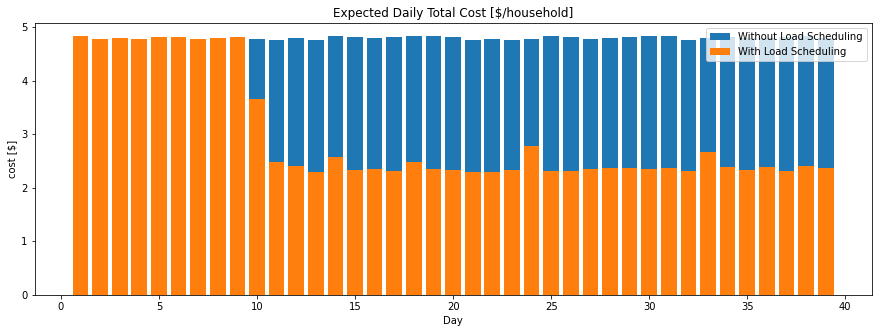

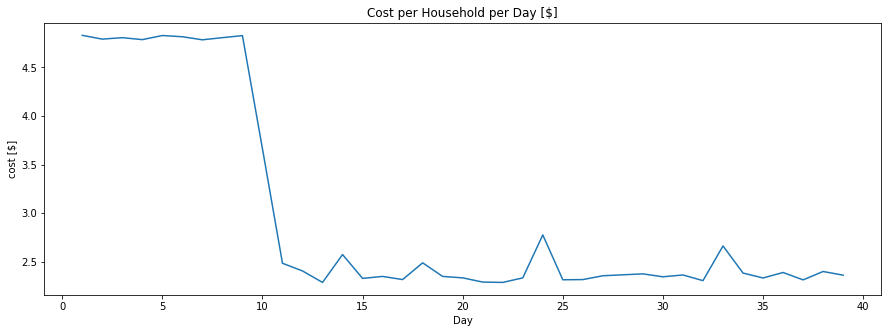

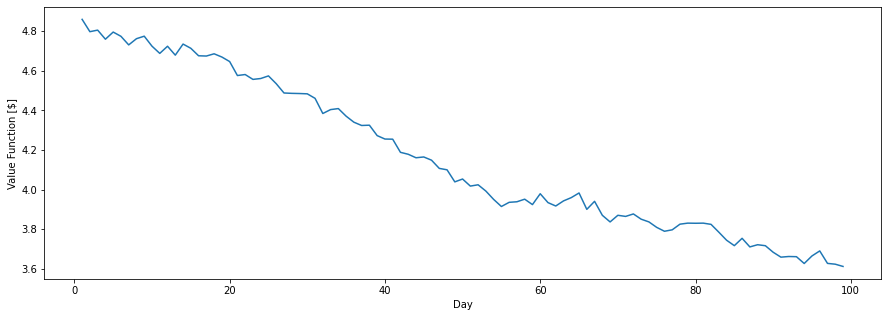

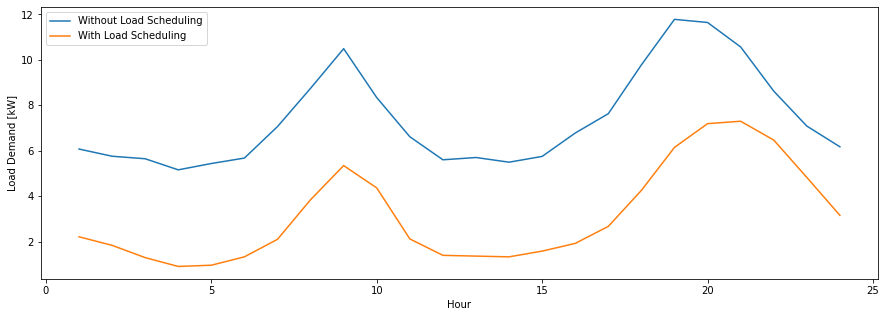

Average electricity consumption reduced: 60.644797658237955 %


In [61]:
#
# Plotting figures for result
#

val_history = np.array(value_history)
val_history=((val_history.reshape(2399,1)))


tot_days = math.floor(input_data[-1,0,0]/24)
p_cntrl_day_hist = P_ctrl_history[2375:2399]
p_base_day_hist = input_data[2376:2400,2,0]
p_max_day_hist =input_data[2376:2400,4,0]

p_cntrl_day_hist = np.array(p_cntrl_day_hist).reshape(24,1)
p_base_day_hist = np.array(p_base_day_hist).reshape(24,1)
p_max_day_hist = np.array(p_max_day_hist).reshape(24,1)

p_base_days = []
p_max_days = []
p_ctrl_days = []
p_tot_days = []
p_tot_cost_days = []
p_max_cost_days = []
val_function_days = []
days = []
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
for i in range(1, tot_days):
    days.append(i)
    data_start = (((i-1)*24))
    data_end = i*24-1

    p_base_day = sum(input_data[data_start:data_end,2,0])
    p_base_days.append(p_base_day) 
    p_max_day = sum(input_data[data_start:data_end,4,0])
    p_max_days.append(p_max_day) 
    p_ctrl_day = sum(P_ctrl_history[data_start:data_end])
    p_ctrl_day_filt = min((p_ctrl_day+p_base_day), (p_max_day+p_base_day))
    p_ctrl_days.append(p_ctrl_day_filt) 
    p_tot_days.append(p_max_day+p_base_day)
    
    p_max_cost_day = sum(np.multiply((input_data[data_start:data_end,2,0] + input_data[data_start:data_end,4,0]), input_data[data_start:data_end,1,0]))
    p_tot_cost_day = sum(P_ctrl_cost_history[data_start:data_end]) + sum(np.multiply((input_data[data_start:data_end,2,0]), input_data[data_start:data_end,1,0]))
    p_tot_cost_filt = min(p_tot_cost_day, p_max_cost_day)/100
    p_tot_cost_days.append(p_tot_cost_filt)
    p_max_cost_days.append(p_max_cost_day/100)
    
    val_function_day = p_max_cost_day/100 + (p_max_cost_day/100)*np.average(val_history[data_start:data_end])/100
    val_function_days.append(val_function_day)

    


plt.figure(figsize=(15, 5))
plt.bar(days[0:39], p_max_cost_days[0:39], label="Without Load Scheduling")
plt.bar(days[0:39], p_tot_cost_days[0:39], label="With Load Scheduling")
plt.title("Expected Daily Total Cost [$/household]")
plt.xlabel("Day")
plt.ylabel("cost [$]")
plt.legend()
plt.show() 

plt.figure(figsize=(15, 5))
plt.plot(days[0:39], p_tot_cost_days[0:39])
plt.title("Cost per Household per Day [$]")
plt.xlabel("Day")
plt.ylabel("cost [$]")
plt.show() 

plt.figure(figsize=(15, 5))
plt.plot(days, val_function_days)
plt.xlabel("Day")
plt.ylabel("Value Function [$]")
plt.show() 


plt.figure(figsize=(15, 5))
x =np.arange(1,25,1)
y1 = (np.add(p_max_day_hist, p_base_day_hist))
y2 = (np.add(p_cntrl_day_hist, p_base_day_hist))

p1 = plt.plot(x, y1, label="Without Load Scheduling")
plt.plot(x, y2, label="With Load Scheduling")
plt.xlabel("Hour")
plt.ylabel("Load Demand [kW]")
plt.legend()
plt.show() 

demand_diff = np.multiply(np.divide(np.subtract(y1,y2), y1),100)
demand_diff_ave = (np.average(demand_diff))
max_demand_diff = max(demand_diff)
min_demand_diff = min(demand_diff)

print("Average electricity consumption reduced:",demand_diff_ave, "%")


(2399, 1)


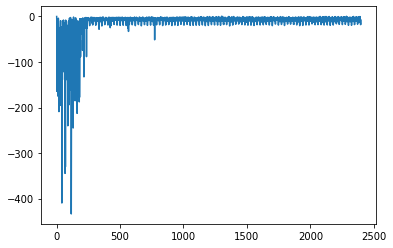

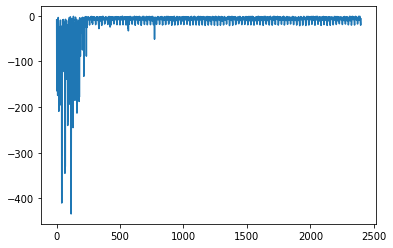

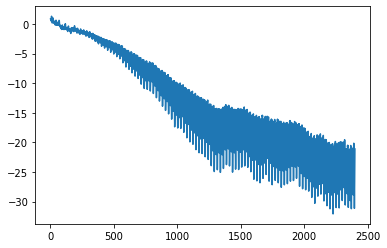

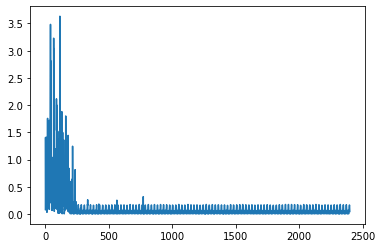

In [60]:

print((val_history.shape))
plt.figure()
plt.plot(input_data[0:2399,0,0], delta_history)
plt.show()

plt.figure()
plt.plot(input_data[0:2399,0,0], reward_history)
plt.show()

plt.figure()
plt.plot(input_data[0:2399,0,0], val_history)
plt.show()

plt.figure()
plt.plot(input_data[0:2399,0,0], [x / 100 for x in P_ctrl_cost_history])
plt.show()